In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
import random
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from rouge import Rouge

In [2]:
# Define a function to format each recipe entry
def format_recipe(recipe_info):
    # Format each component of the recipe entry
    recipe_entry = ""
    for key, value in recipe_info.items():
        if isinstance(value, list):
            value = ", ".join(value)
        recipe_entry += f"{key}: {value}\n"
    recipe_entry += "\n"  # Add a newline after each recipe entry
    return recipe_entry

# Define a function to read recipes from a file and format them
def process_recipes_file(file_path):
    formatted_recipes = []  # List to store formatted recipe entries
    with open(file_path, "r") as file:
        lines = file.readlines()
        recipe_info = {}  # Dictionary to store information for each recipe
        for line in lines:
            line = line.strip()  # Remove leading/trailing whitespace
            if line:  # Skip empty lines
                key_value = line.split(": ", 1)  # Split each line into key-value pair
                if len(key_value) == 2:
                    key, value = key_value
                    if key == "Name":
                        if recipe_info:  # If recipe_info is not empty, format the previous recipe entry
                            formatted_recipe = format_recipe(recipe_info)
                            formatted_recipes.append(formatted_recipe)
                        recipe_info = {}  # Reset recipe_info for the next recipe
                    if key == "Keywords":
                        recipe_info[key] = value.split(", ")  # Convert keywords to list
                    else:
                        recipe_info[key] = value
        # Format the last recipe entry
        formatted_recipe = format_recipe(recipe_info)
        formatted_recipes.append(formatted_recipe)
    return formatted_recipes

# Define file paths
input_file_path = "processed_recipes_main.txt"
output_file_path = "formatted_recipes_main.txt"

# Process recipes file and format recipes
formatted_recipes = process_recipes_file(input_file_path)

# Write formatted recipes to output file
with open(output_file_path, "w") as file:
    file.writelines(formatted_recipes)

print("Recipes formatted and saved to", output_file_path)


Recipes formatted and saved to formatted_recipes_main.txt


In [3]:
# Function to calculate perplexity
def calculate_perplexity(loss):
    return math.exp(loss)

# Define file path
file_path = "formatted_recipes_main.txt"

# Load the text file
text = open(file_path, "r").read()

# Tokenizer for GPT-2
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Encode the text
encoded_text = tokenizer.encode(text, max_length=512, truncation=True, padding="max_length")
encoded_tensor = torch.tensor(encoded_text).unsqueeze(0)

# Prepare training dataset
dataset = torch.utils.data.TensorDataset(encoded_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8)

# Create GPT-2 model
model = GPT2LMHeadModel.from_pretrained("gpt2")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

epochs = 200
training_loss_plt_arr = []
perplexity_plt_arr = []

for epoch in range(epochs):
    epoch_loss = 0.0  # Track total loss for the epoch
    model.train()
    for batch in dataloader:
        batch_input = batch[0].to(model.device)

        optimizer.zero_grad()

        outputs = model(input_ids=batch_input, labels=batch_input)
        loss = outputs.loss

        loss.backward()
        clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
        optimizer.step()

        epoch_loss += loss.item()

    # Average epoch loss
    epoch_loss /= len(dataloader)
    training_loss_plt_arr.append(epoch_loss)
    
    # Calculate perplexity and store
    perplexity = calculate_perplexity(epoch_loss)
    perplexity_plt_arr.append(perplexity)

    # Print training loss
    if (epoch + 1) % 20 == 0:
        print(f"Epoch: {epoch + 1}/{epochs}, Loss: {epoch_loss:.5f}, Perplexity: {perplexity:.5f}")

    # Adjust learning rate
    scheduler.step()

# Save the trained model
model.save_pretrained("trained_recipe_GPT2_model")

print("Training complete! Model saved as 'trained_recipe_GPT2_model'")


Epoch: 20/200, Loss: 1.76927, Perplexity: 5.86656
Epoch: 40/200, Loss: 0.75925, Perplexity: 2.13667
Epoch: 60/200, Loss: 0.25038, Perplexity: 1.28451
Epoch: 80/200, Loss: 0.08832, Perplexity: 1.09234
Epoch: 100/200, Loss: 0.02887, Perplexity: 1.02929
Epoch: 120/200, Loss: 0.01536, Perplexity: 1.01548
Epoch: 140/200, Loss: 0.01240, Perplexity: 1.01248
Epoch: 160/200, Loss: 0.02725, Perplexity: 1.02763
Epoch: 180/200, Loss: 0.00323, Perplexity: 1.00323
Epoch: 200/200, Loss: 0.01665, Perplexity: 1.01679
Training complete! Model saved as 'trained_recipe_GPT2_model'


## Visualization

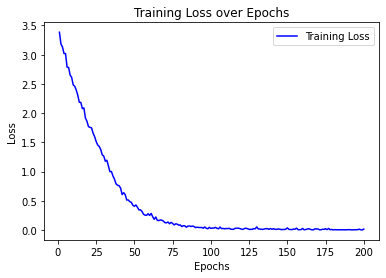

In [11]:
# Plot the Training Loss graph
epochs = range(1, len(training_loss_plt_arr) + 1)
plt.plot(epochs, training_loss_plt_arr,
         label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

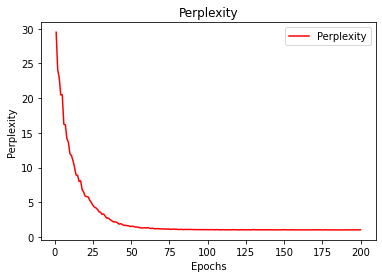

In [10]:
# Plotting perplexity
epochs = range(1, len(training_loss_plt_arr) + 1)
plt.plot(epochs, perplexity_plt_arr, 'r', label='Perplexity')
plt.title('Perplexity')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.legend()
plt.show()


## Model Result

In [3]:
# Load the trained model
model_path = "trained_recipe_GPT2_model"
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define input prompt
input_prompt = "I'm craving Chicken Biryani."

# Tokenize input prompt
input_ids = tokenizer.encode(input_prompt, return_tensors="pt").to(device)

# Generate recipe suggestion and get attention weights
output = model.generate(
    input_ids,
    max_length=600,  # Increased max_length
    num_return_sequences=1,
    no_repeat_ngram_size=2,
    top_p=0.85,  # Adjusted top_p
    temperature=0.8,  # Adjusted temperature
    do_sample=True,
    top_k=60,  # Adjusted top_k
    early_stopping=False,
    pad_token_id=tokenizer.eos_token_id,
    output_attentions=True,
)

# Decode the generated recipe
recipe = output[0]
generated_text = tokenizer.decode(recipe, skip_special_tokens=True)

# Print the generated recipe
print("Recipe suggestion:")
print(generated_text)

Recipe suggestion:
I'm craving Chicken Biryani.

I've been craving this recipe for a long time, and I've always had a craving for Chicken Thigh & Leg. So when I saw this post, I thought, "Wow, this is really good. I'd love to try it out. Let's see how this turns out." So I made this Chicken Leg Thighed Chicken recipe from scratch. It's so simple, you can use any kind of chicken or veggie you like, but make sure to use beef, chicken, or vegetable broth. Plus, it's full of flavor and health benefits. Easy to Make
Difficulty Level: Very Hard
Health Benefits: Low
Rating: 4.5
Images: https://img.sndimg-img, https/c/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/YUeirxMLQaeE1h3v3qnM_229%20Chicken%205Thigh%206Leg%204%202%22dess.jpg
RecipeInstructions: Toss 2 cups chicken with sugar, Let stand for 45 minutes, stirring occasionally, Transfer biryan mixture to food processor, Add yogurt and process until smooth, Strain through fine sieve Pour into baking pan or transfer to ice cr

## Evaluation Metrics

In [4]:
# reference recipes
references = [
    "Soak saffron in warm milk before blending it with chiles, onions, ginger, and various spices to form a paste. Marinate chicken thighs and legs in this mixture with yogurt, then fry with onions, tomatoes, and cook with rice, nuts, and raisins. Garnish with fried onions.",
    "Begin by soaking saffron in milk and creating a spice paste with ingredients like ginger, garlic, and cardamom. Use this paste to marinate the chicken, which is then fried with tomatoes and combined with rice, cashews, and almonds. Finish the dish with saffron-colored rice and a garnish of onions and eggs.",
    "Prepare a marinade of yogurt and a blend of spices including saffron, cardamom, and cloves for the chicken. After marinating for a few hours, cook the chicken with tomatoes and add rice. Garnish the biryani with fried onions, nuts, and hard-boiled eggs for a rich presentation."
]

In [5]:
# Perplexity Calculation
def calculate_perplexity(loss):
    return math.exp(loss)

# Calculate perplexity from training loss
training_loss = 0.01665
perplexity = calculate_perplexity(training_loss)
print(f"Perplexity: {perplexity}")

Perplexity: 1.0167893837553101


In [7]:
# BLEU score
tokenized_references = [ref.split() for ref in references]
tokenized_generated = generated_text.split()

# Compute BLEU score considering up to bi-grams
bleu_score = sentence_bleu(tokenized_references, tokenized_generated, weights=(0.5, 0.5))
print("BLEU Score:", bleu_score)

BLEU Score: 0.054323228744177283


In [16]:
combined_references = ' '.join(references)

# Compute ROUGE score
rouge = Rouge()
scores = rouge.get_scores(generated_text, combined_references, avg=True)
print("ROUGE Scores:", scores['rouge-1'])

ROUGE Scores: {'r': 0.35, 'p': 0.1044776119402985, 'f': 0.16091953668912679}
